<a href="https://colab.research.google.com/github/grzabrodskiy/ImageRec/blob/main/src/test_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FER Project **test functions**


---
```
EmotionRecognition(path, model, num = 4)
```
N.B. Please note that the test files are expected to be in the following format in the path directory:
```
{path}/[label]/file.jpg
```
where `label` is one of the emption names

For example:
`.../Anger/001.jpg`

---


```
EmotionRecognitionVideo (path, model = 'cnn')
```
---

Models are expected to be pre-trained as saved MODEL_DIR

---

N.B. For cnn model execution you may require cuda environment



In [2]:
import torch
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)


Mounted at /content/drive
cuda:0


In [3]:
print (device)

cuda:0


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
import random
import pprint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import shutil
from torchvision.utils import make_grid
import pickle
from skimage import data
from skimage.feature import Cascade
from matplotlib import patches
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import color
from PIL import Image
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import validation

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

import cv2
import numpy as np
import matplotlib.image as mpimg
from pylab import rcParams
import random
import pprint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import shutil
from torchvision.utils import make_grid
import pickle




In [5]:
CLASS_MAP = {'Surprise': 1, 'Fear': 2, 'Disgust': 3, 'Happiness': 4, 'Sadness': 5, 'Anger': 6, 'Neutral': 7}
CLASS_NAMES = list(CLASS_MAP.keys())
CLASS_NUM = len(CLASS_NAMES) # number of features

In [6]:
VIDEO_FILE = 'drive/MyDrive/CW_Folder/Video/video.mp4'
TEST_DIR = 'drive/My Drive/CW_Folder/Data/test/sorted/'
MODEL_DIR = 'drive/My Drive/CW_Folder/Models/'

In [7]:
def loadClassifier_nn():
  if device.type == 'cpu':
    classifier_nn = torch.load(f'{MODEL_DIR}/classifier_nn', map_location=torch.device('cpu'))
  else: #cuda
    classifier_nn = torch.load(f'{MODEL_DIR}/classifier_nn')
  return classifier_nn

In [8]:
def loadClassifiers():
  classifier_nn = loadClassifier_nn()

  with open(f'{MODEL_DIR}/classifier2', 'rb') as cf2_file:
    classifier2 = pickle.load(cf2_file)
  with open(f'{MODEL_DIR}/classifier2', 'rb') as cf3_file:
    classifier3 = pickle.load(cf3_file)
  return classifier_nn, classifier2, classifier3

#Part 1

In [9]:
def loadData(path):
  img_list = dict()
  labels = dict()
  num_images = dict()
  img_data = dict()


  img_data_list = []
  labels_list = []
  for label in CLASS_NAMES:
    if label == '': 
      continue
    
    for img in os.listdir(f'{path}/{label}'):
      input_img = cv2.imread(f'{path}{label}/{img}')
      img_data_list.append(input_img)
      labels_list.append(label)

  img_list = img_data_list
  labels = np.array(labels_list)

  img_list_x = []
  for img in img_list:
    img_x = rgb2gray(img)
    img_list_x.append(img_x)
  img_data = np.array(img_list_x).astype('float32') /255.0
  img_data = img_data.reshape((len(img_data), -1)) # Flatten the images
  img_data_o = np.array(img_list)#.astype('float32') /255.0
  #img_data_o = img_data.reshape((len(img_data_o), -1)) # Flatten the images

  num_images = img_data.shape[0]
  return img_data, labels, num_images, img_data_o

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(0.5) * inp + np.asarray(0.5)
    inp = np.clip(inp, 0, 1)    
    plt.imshow(inp)
    plt.title(title)

In [11]:
def report(classifier, expected, predicted):
  print("Classification report for classifier %s:\n%s\n"
        % (classifier, metrics.classification_report(expected, predicted)))

  cm = confusion_matrix(labels['test'], predicted)
  plt.matshow(cm)
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.xticks(ticks=range(0,7), labels=list(CLASS_MAP.keys()))
  plt.yticks(ticks=range(0,7), labels=list(CLASS_MAP.keys()))
  plt.show()

In [12]:
img_list, labels, _, _ = loadData(TEST_DIR)

In [15]:
def visualize_model_nn(path, num_images=4):
    

  data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5, inplace=True)
    ]),
  }

  image_dataset = datasets.ImageFolder(f'{path}', data_transforms['test'])
  dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=4,
                                             shuffle=True, num_workers=2)
       
  model = loadClassifier_nn()
 
  was_training = model.training
  model.eval()
  images_so_far = 0
  class_names = image_dataset.classes

  with torch.no_grad():
      for i, (inputs, labels) in enumerate(dataloader):
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          for j in range(inputs.size()[0]):
              images_so_far += 1
              ax = plt.subplot(num_images, 4, images_so_far)
              ax.axis('off')
              
              imshow(inputs.cpu().data[j]) # move back the data to the CPU for visualisation
              ax.set_title(f"{class_names[preds[j]]}", fontsize=14)

              if images_so_far == num_images:
                  model.train(mode=was_training)
                  return
      model.train(mode=was_training)

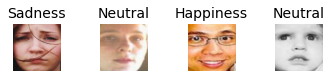

In [16]:
visualize_model_nn(TEST_DIR)

In [17]:
def predict(path):
  cf1, cf2, cf3 = loadClassifiers()
  img_data, labels, count, original_data = loadData(path)
  
  cf2.fit(img_data, labels)
  predicted2 = cf2.predict(img_data)
  expected2 = labels
  
  cf3.fit(img_data, labels)
  predicted3 = cf3.predict(img_data)
  expected3 = labels
  return predicted2, expected2, predicted3, expected3, img_data, original_data

In [18]:
predicted2, expected2, predicted3, expected3, _, _ = predict(TEST_DIR)

#EmotionRecognition function

In [19]:
def EmotionRecognition(path, model, num = 4):

    predicted2, expected2, predicted3, expected3, img_data, original_data = predict(path)

    if model == 'cnn':
      visualize_model_nn(path)
      return
    elif model == 'svm':
      pred_ = predicted2
      exp_ = expected2
    elif model == 'randomforest':
      pred_ = predicted3
      exp_ = expected3
    else: 
      print('unknown model\nchoose from cnn|svm|randomforest')
      return

# Create a display of samples
    fig, axs = plt.subplots(1, num)

    for i in range(4):
      index = random.randint(0, len(img_data)-1) # pick a random index
      img = original_data[index]
      img = img.reshape(100, 100, 3) #channels
      label = exp_[index]
      axs[i].axis('off')
      axs[i].imshow(img[:,:,0])
      axs[i].set_title(label, fontsize = 18)

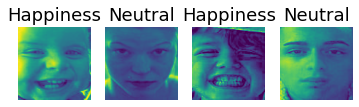

In [20]:
EmotionRecognition(TEST_DIR, 'svm')

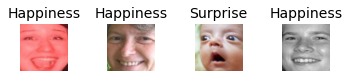

In [21]:
EmotionRecognition(TEST_DIR, 'cnn')

#Part 2

In [22]:
def loadVideo(path, display = True):
  vidcap = cv2.VideoCapture(path)
  success,image = vidcap.read()
  if success:
    if display:
      print('Video loaded: ', path) 
  else: 
    return [], 0
  count = 0
  frames = []
  while success:
    #cv2.imwrite("CW/frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    frames.append(image)
    #print('Reading frame: ', count, success)
    count += 1

  if display:
    print ('Saved frames ', count)
  vidcap.release()
  cv2.destroyAllWindows()
  return frames, count

Video loaded:  drive/MyDrive/CW_Folder/Video/video.mp4
Saved frames  206


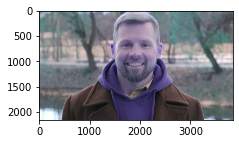

In [23]:
# free download from ttps://www.pexels.com/video/
frames, count = loadVideo('drive/MyDrive/CW_Folder/Video/video.mp4')
if len(frames) > 0:
  frame = frames[0]
  plt.figure(figsize = (20,2))

  plt.imshow(frame)

In [24]:
def select_face(frame, display = True):
  # Load the trained file from the module root.
  trained_file = data.lbp_frontal_face_cascade_filename()
  # Initialize the detector cascade.
  detector = Cascade(trained_file)
  detected = detector.detect_multi_scale(img=frame,
                                        scale_factor=1.2,
                                        step_ratio=1,
                                        min_size=(400, 400),
                                        max_size=(1000, 1000))
  if display:
    plt.figure(figsize = (20,2))
    plt.imshow(frame)
    img_desc = plt.gca()
    #plt.set_cmap('gray')
    for patch in detected:
        img_desc.add_patch(
            patches.Rectangle(
                (patch['c'], patch['r']),
                patch['width'],
                patch['height'],
                fill=False,
                color='r',
                linewidth=2
            )
        )
    plt.show()
  return detected


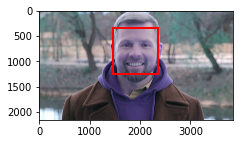

In [25]:
detected = select_face(frame)

In [26]:
def extract_face(frame, display = True):

  detected = select_face(frame, False)
  if (len(detected)<=0):
    return frame

  faces = []
  for face in detected:
    x, y = face['r'], face['c']
    w, h = face['width'], face['height']
    img_face = frame[x:x+w, y:y+h]
    image_resized = resize(img_face, (100, 100),
                        anti_aliasing=True)
    faces.append(image_resized)
    if display:
      plt.figure(figsize = (20,3))
      plt.imshow(image_resized)
  return faces

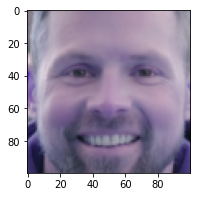

In [27]:
faces = extract_face(frame)

In [34]:
def tensorize(frame):
  transform = transforms.Compose([
      transforms.PILToTensor()
  ])
  im = Image.fromarray(np.uint8(color.gray2rgb(frame)*255))
  img_tensor = transform(im).cuda()
  #print(img_tensor.size())
  #print(img_tensor)
  #img_tensor.resize_(1, 3, 100, 100)
  img_tensor = img_tensor.unsqueeze(0)
  #print(img_tensor)
  return img_tensor.float()

In [35]:
def predict_face(frame, model = 'cnn', display = True):
  cf1, cf2, cf3 = loadClassifiers()
  if model == 'svm':
    cf = cf2
  elif model == 'randomforest':
    cf = cf3
  faces = extract_face(frame, display)
  face_img = faces[0]
  face_img = rgb2gray(faces[0])

  if model == 'cnn':
    img_tensor = tensorize(face_img)
    a = cf1(img_tensor.float())
    _, preds = torch.max(a, 1)
    return CLASS_NAMES[preds]


  data = np.array([face_img]).astype('float32') /255.0
  data = data.reshape((len(data), -1)) # Flatten the images
  predicted = cf.predict(data)
  return predicted[0]

Happiness


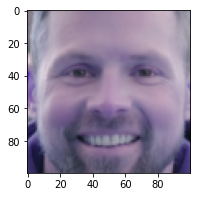

In [36]:
print(predict_face(frame, 'svm')) ## default is CNN

#EmotionRecognitionVideo function

In [37]:
def EmotionRecognitionVideo (path, model = 'cnn'):
  frames, count = loadVideo(path, False)
  if (count == 0):
    print('video cannot be loaded:', path)
    return

  frame = frames[0] # take the first frame
  select_face(frame)
  print(predict_face(frame, model, False))

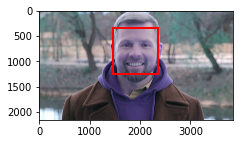

Happiness


In [38]:
EmotionRecognitionVideo(VIDEO_FILE, 'randomforest')

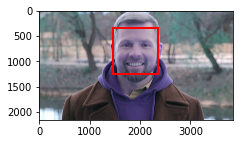

tensor([[[124, 126, 129,  ..., 143, 155, 158],
         [125, 127, 129,  ..., 145, 155, 157],
         [126, 129, 130,  ..., 154, 157, 157],
         ...,
         [ 56,  54,  50,  ...,  64,  69,  70],
         [ 57,  54,  51,  ...,  63,  70,  69],
         [ 56,  54,  50,  ...,  64,  69,  69]],

        [[124, 126, 129,  ..., 143, 155, 158],
         [125, 127, 129,  ..., 145, 155, 157],
         [126, 129, 130,  ..., 154, 157, 157],
         ...,
         [ 56,  54,  50,  ...,  64,  69,  70],
         [ 57,  54,  51,  ...,  63,  70,  69],
         [ 56,  54,  50,  ...,  64,  69,  69]],

        [[124, 126, 129,  ..., 143, 155, 158],
         [125, 127, 129,  ..., 145, 155, 157],
         [126, 129, 130,  ..., 154, 157, 157],
         ...,
         [ 56,  54,  50,  ...,  64,  69,  70],
         [ 57,  54,  51,  ...,  63,  70,  69],
         [ 56,  54,  50,  ...,  64,  69,  69]]], device='cuda:0',
       dtype=torch.uint8)
tensor([[[[124, 126, 129,  ..., 143, 155, 158],
          [125,

In [39]:
EmotionRecognitionVideo(VIDEO_FILE)